In [291]:
%matplotlib inline
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)


In [270]:
def add_confidence(row, agg_data):
    data = agg_data[agg_data['id'] == row['id']]
    return data.iloc[0]['label:confidence']


def load_dataset(folder):
    def add_fields(df,iteration):
        df['iteration'] = iteration
        df['domain'] = folder[0].split('-')[0]
        return df
         
    agg_list = []
    full_list = []
    test_list = []
    for f in folder:

        iteration = 2 if 'it3' in f else 1
        agg = pd.read_csv('{}/agg.csv'.format(f))
        agg = add_fields(agg,iteration)
        agg['raw_text'] = agg.apply(
        lambda row: BeautifulSoup(row['text_html'], "lxml").text.replace(':[OBJECT_A]', '').replace(':[OBJECT_B]', ''),
        axis=1)
        agg_list.append(agg)
        
        
        full = pd.read_csv('{}/full.csv'.format(f))
        full = add_fields(full,iteration)
        full_list.append(full)
        
        test = pd.read_csv('{}/test.csv'.format(f))
        test = add_fields(test,iteration)
        test_list.append(test)
    return pd.concat(agg_list), pd.concat(full_list), pd.concat(test_list)
   
        

In [273]:
jbt_agg, jbt_full, jbt_test = load_dataset(['jbt-data', 'jbt-data-it2','jbt-data-it3'])
compsci_agg, compsci_full, compsci_test = load_dataset(['compsci-data', 'compsci-data-it2', 'compsci-data-it3'])
brands_agg, brands_full, brands_test = load_dataset(['brands-data-100', 'brands-data-400', 'brands-data-it2', 'brands-data-it3'])

In [304]:
jbt_full['_trust'].value_counts()

1.0000    3865
0.8750     915
0.9167     777
0.9000     672
0.8889     627
0.9583     579
0.8333     454
0.8571     431
0.9091     325
0.8824     324
0.9286     296
0.9375     287
0.8485     214
0.9444     203
0.9474     184
0.9412     147
0.8235     143
0.9333     136
0.9130     134
0.8000     112
0.8182     109
0.9524     106
0.7273     106
0.8710      96
0.8621      95
0.9231      93
0.9048      88
0.9545      85
0.7857      85
0.8929      84
0.7826      72
0.9565      72
0.8667      68
0.8636      66
0.7778      59
0.8421      56
0.8947      56
0.8261      56
0.8462      41
0.7143      32
0.7692      32
0.7500      12
Name: _trust, dtype: int64

In [309]:
columns = ['id','domain', 'object_a', 'object_b', 'sentence', 'it_1_confidence', 'it_2_confidence', 
           'better_count', 'worse_count','none_count', 'most_frequent_label', 'most_frequent_count', 
           'it_1_judgments', 'it_2_judgments', 'sentence_html']


def add_columns(agg,full):
    df = pd.DataFrame(columns=columns)
    for sid in full['id'].unique():
        better_count = 0
        better_trust = 0
        worse_count = 0
        worse_trust = 0
        none_count = 0
        none_trust = 0
        it_1_judgments = 0
        it_2_judgments = 0
        most_frequent = ''
        f_subset = full[full['id'] == sid]
        for i, f_row in f_subset.iterrows():
            label = f_row['label']
            _iteration = f_row['iteration']
            if _iteration == 1:
                it_1_judgments +=1
            else:
                it_2_judgments += 1
                
            if 'BETTER' == label:
                better_count +=1
                better_trust += f_row['_trust']
            elif 'WORSE' == label:
                worse_count += 1
                worse_trust += f_row['_trust']
            else:
                none_count +=1
                none_trust += f_row['_trust']
        winner = sorted([(better_trust, better_count, 'BETTER'), (worse_trust, worse_count, 'WORSE'),
                         (none_trust, none_count, 'NONE')],reverse=True)
        most_frequent_label = winner[0][2]
        most_frequent_count = winner[0][1]
        
        a_it1 = agg[(agg['id'] == sid) & (agg['iteration'] == 1)]
        a_it2 = agg[(agg['id'] == sid) & (agg['iteration'] == 2)]
        

        if len(a_it1) == 1 and len(a_it2) == 1:
            content = [sid,a_it1.iloc[0]['domain'], a_it1.iloc[0]['a'], a_it1.iloc[0]['b'],a_it1.iloc[0]['raw_text'],
                       a_it1.iloc[0]['label:confidence'],a_it2.iloc[0]['label:confidence'],
                       better_count,worse_count,none_count,most_frequent_label,most_frequent_count,it_1_judgments,it_2_judgments,a_it1.iloc[0]['text_html']]
            df.loc[len(df)] =content
    
    df['judgments'] = df['it_1_judgments'] + df['it_2_judgments']
    it1_c = df['it_1_confidence'] * (df['it_1_judgments']/ df['judgments'])
    it2_c = df['it_2_confidence'] * (df['it_2_judgments']/ df['judgments'])
    df['confidence'] = it1_c+it2_c
    
    df['most_frequent_percentage'] = df['most_frequent_count'] / df['judgments']
    numeric_cols =['confidence', 'most_frequent_count', 'most_frequent_percentage','judgments']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

    
    return df

In [310]:
compsci = add_columns(compsci_agg,compsci_full)

In [311]:
brands = add_columns(brands_agg,brands_full)

In [312]:
jbt = add_columns(jbt_agg,jbt_full)

In [313]:
combi = pd.concat([compsci,brands,jbt])

In [314]:
print('All rows: {} Unique: {}'.format(len(combi), len(combi['id'])))

All rows: 7275 Unique: 7275


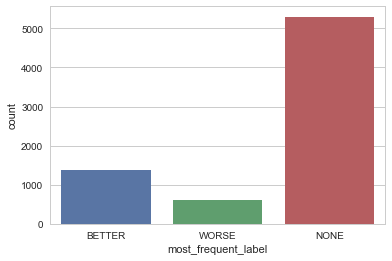

In [315]:
sns.countplot(x="most_frequent_label", data=combi);

In [316]:
from sklearn.model_selection import train_test_split

train_i, test_i = train_test_split(combi,stratify=combi['most_frequent_label'], test_size=0.2,random_state=42)
print('{} {} {}'.format(len(train_i), len(test_i), (len(train_i)+ len(test_i))))
combi.to_csv('all-data.csv')
train_i.to_csv('data.csv')
test_i.to_csv('held-out-data.csv')

5820 1455 7275


In [318]:
combi[combi['most_frequent_percentage'] == 0.5]

,id,domain,object_a,object_b,sentence,it_1_confidence,it_2_confidence,better_count,worse_count,none_count,most_frequent_label,most_frequent_count,it_1_judgments,it_2_judgments,sentence_html,judgments,confidence,most_frequent_percentage
164,P2576169638,compsci,Java,Groovy,The new version of the Groovy programming lang...,0.6657,0.6784,3,0,3,NONE,3,3,3,"The new version of the <span style=""color: #9A...",6,0.672050,0.5
196,R2839991108,compsci,Integer,Floating-point,This is most likely done to optimize for Integ...,0.6446,0.6513,3,0,3,NONE,3,3,3,This is most likely done to optimize for <span...,6,0.647950,0.5
222,N2221112246,compsci,Java,Groovy,@Slava: FUD! Shameless FUD! Groovy is definite...,0.4748,0.5217,3,1,2,BETTER,3,4,2,"@Slava: FUD! Shameless FUD! <span style=""color...",6,0.490433,0.5
278,R2852378827,compsci,Python,JavaScript,This makes JavaScript in my experience harder ...,0.6700,0.5217,2,4,2,WORSE,4,6,2,"This makes <span style=""color: #9A14B2; font-w...",8,0.632925,0.5
314,P2504608892,compsci,MySQL,PostgreSQL,"The GIS functions of MySQL, and even better on...",0.5167,0.5111,3,3,0,WORSE,3,4,2,"The GIS functions of <span style=""color: #9A14...",6,0.514833,0.5
325,D538988864,compsci,CUDA,OpenCL,CUDA is still strong because it has better sup...,0.7278,1.0000,3,2,1,BETTER,3,4,2,"<span style=""color: #9A14B2; font-weight: bold...",6,0.818533,0.5
352,G1018532288,compsci,Swift,Objective-C,I am very skeptical that Swift is faster than ...,0.5033,0.5106,4,4,0,WORSE,4,6,2,"I am very skeptical that <span style=""color: #...",8,0.505125,0.5
359,F794674342,compsci,Java,Smalltalk,"(FWIW, Smalltalk (and to a much lesser extent,...",0.5106,0.5106,3,0,3,BETTER,3,4,2,"(FWIW, <span style=""color: #9A14B2; font-weigh...",6,0.510600,0.5
402,R2857951106,compsci,Oracle,PostgreSQL,"This one I just checked about, and Oracle stil...",0.5032,0.5116,3,0,3,NONE,3,4,2,"This one I just checked about, and <span style...",6,0.506000,0.5
422,J1478419594,compsci,Windows XP,Windows Vista,It was better than Windows Vista; it was bette...,0.4777,0.5000,2,1,3,NONE,3,4,2,"It was better than <span style=""color: #9A14B2...",6,0.485133,0.5


In [326]:
combi[combi.duplicated('id',keep=False)].sort_values('sentence')

,id,domain,object_a,object_b,sentence,it_1_confidence,it_2_confidence,better_count,worse_count,none_count,most_frequent_label,most_frequent_count,it_1_judgments,it_2_judgments,sentence_html,judgments,confidence,most_frequent_percentage
1394,B174032983,brands,Apple,Google,"Again, Facebook is growing faster than Apple a...",1.0000,1.0000,0,0,5,NONE,5,3,2,"Again, Facebook is growing faster than <span s...",5,1.00000,1.0
2397,B174032983,jbt,google,facebook,"Again, facebook is growing faster than Apple a...",1.0000,1.0000,5,0,0,BETTER,5,3,2,"Again, <span style=""color: #9A14B2; font-weigh...",5,1.00000,1.0
1274,B231874454,brands,Google,Amazon,"Amazon is innovating on Android, faster than G...",1.0000,1.0000,5,0,0,BETTER,5,3,2,"<span style=""color: #9A14B2; font-weight: bold...",5,1.00000,1.0
207,B231838818,brands,Google,Amazon,"Amazon, Google and Microsoft are all solid cho...",1.0000,1.0000,0,0,5,NONE,5,3,2,"<span style=""color: #9A14B2; font-weight: bold...",5,1.00000,1.0
2178,F801586602,brands,Apple,Amazon,"Generally, both Amazon and Google are superior...",1.0000,1.0000,5,0,0,BETTER,5,3,2,"Generally, both <span style=""color: #9A14B2; f...",5,1.00000,1.0
1647,F801586602,jbt,google,amazon,"Generally, both amazon and google are superior...",1.0000,1.0000,0,0,5,NONE,5,3,2,"Generally, both <span style=""color: #9A14B2; f...",5,1.00000,1.0
2081,H1201025316,brands,Google,Amazon,I'm finding that Amazon 's selection of apps a...,1.0000,1.0000,0,5,0,WORSE,5,3,2,"I'm finding that <span style=""color: #9A14B2; ...",5,1.00000,1.0
727,H1201025316,jbt,google,amazon,I'm finding that amazon 's selection of apps a...,1.0000,1.0000,0,5,0,WORSE,5,3,2,"I'm finding that <span style=""color: #9A14B2; ...",5,1.00000,1.0
1986,I1257165572,brands,Google,Amazon,"In fact, Amazon did poorly in Google overall i...",1.0000,1.0000,0,3,2,WORSE,3,3,2,"In fact, <span style=""color: #9A14B2; font-wei...",5,1.00000,0.6
886,I1257165572,jbt,google,amazon,"In fact, amazon did poorly in google overall i...",0.3478,1.0000,1,1,3,NONE,3,3,2,"In fact, <span style=""color: #9A14B2; font-wei...",5,0.60868,0.6
